In [1]:
import os
import glob
import random

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


learning_rate = 0.001
batch_size = 10
epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [2]:
train_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\train"
test_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\test"
val_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\val"

path1 = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\annotation_rose.csv"
path2 = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5\\annotation_tulip.csv"
dfs = []
tmp = pd.read_csv(path1, sep=',', header=None, encoding='UTF-16') 
dfs.append(tmp)
tmp = pd.read_csv(path2, sep=',', header=None, encoding='UTF-16')
dfs.append(tmp)
df = pd.concat(dfs)
df.drop(1, axis=1, inplace=True)
df.rename(columns={0: 'absolute_way', 2: 'class_img'}, inplace=True)
df.reset_index(inplace=True)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

In [3]:
def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)


def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)



for i in range(576):
    load_train(df, train_path, i)
for i in range(720,1296):
    load_train(df, train_path, i)
for i in range(576,648):
    load_test(df,test_path,i)
for i in range(1296,1368):
    load_test(df,test_path,i)
for i in range(648,720):
    load_val(df,val_path,i)
for i in range(1368,1440):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
val_list = glob.glob(os.path.join(val_path, '*.jpg'))

# split our data into train and test sets
train_list, val_list = train_test_split(train_list, test_size=0.1)    

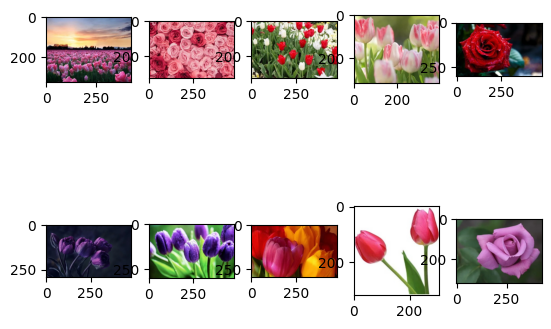

In [4]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()


In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
#Image Augmentation